##6.2. Prepare test candidates for Reranker



We prepare the same as Part 6.1 for test candidates, but using information for Weeks 1 to 5 (Train + Test).

Refer to Part 6.1 on background behind the steps.

**Set up rapids and GPU**

In [ ]:
# Run this to check if GPU is used
!nvidia-smi

Sat Apr 15 21:15:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    48W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Run this each time to get the RAPIDS-Colab install files and test check GPU
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
Traceback (most recent call last):
  File "/content/rapidsai-csp-utils/colab/pip-install.py", line 28, in <module>
    if ('K80' not in gpu_name):
TypeError: a bytes-like object is required, not 'str'


**Prepare files**

In [ ]:
VER = 3

import pandas as pd, numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import os, sys, pickle, glob, gc
from collections import Counter

# !pip install pandarallel
from pandarallel import pandarallel
import cudf, itertools
print('We will use RAPIDS version',cudf.__version__)

We will use RAPIDS version 23.04.00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%time
# CACHE FUNCTIONS
def read_file(f):
    return cudf.DataFrame( data_cache[f] )
def read_file_to_cache(f):
    df = pd.read_parquet(f)
    df.ts = (df.ts/1000).astype('int32')
    df['type'] = df['type'].map(type_labels).astype('int8')
    return df

# CACHE THE DATA ON CPU BEFORE PROCESSING ON GPU
data_cache = {}
type_labels = {'clicks':0, 'carts':1, 'orders':2}

# we use those from train and test dataset (weeks 1 to 5)
files = glob.glob('/content/drive/MyDrive/0.capstone/covisit_prepare/*_parquet/*')
for f in files: data_cache[f] = read_file_to_cache(f)

# CHUNK PARAMETERS
READ_CT = 5
CHUNK = int( np.ceil( len(files) / 6 ))
print(f'We will process {len(files)} files, in groups of {READ_CT} and chunks of {CHUNK}.')

We will process 146 files, in groups of 5 and chunks of 25.
CPU times: user 32.7 s, sys: 9.09 s, total: 41.7 s
Wall time: 26.6 s


**Covisitation 1: "Carts Orders" Co-visitation Matrix - Type Weighted**

- Split into parts to prevent memory errors
- Select up to 30 most recent click, cart, orders
- Identify pairs that occurred within one day
- wgt = frequency of interaction of each pair, weighted by type of aid_y
- output top 30 pairs of each aid_x by weight *(this was increased vs rule based approach)*

In [ ]:
%%time
type_weight = {0:0.5, 1:9, 2:2}

# USE SMALLEST DISK_PIECES POSSIBLE WITHOUT MEMORY ERROR
DISK_PIECES = 2
SIZE = 1.86e6/DISK_PIECES

# COMPUTE IN PARTS FOR MEMORY MANGEMENT
for PART in range(DISK_PIECES):
    print()
    print('### DISK PART',PART+1)
    
    # MERGE IS FASTEST PROCESSING CHUNKS WITHIN CHUNKS
    # => OUTER CHUNKS
    for j in range(6):
        a = j*CHUNK
        b = min( (j+1)*CHUNK, len(files) )
        print(f'Processing files {a} thru {b-1} in groups of {READ_CT}...')
        
        # => INNER CHUNKS
        for k in range(a,b,READ_CT):
            # READ FILE
            df = [read_file(files[k])]
            for i in range(1,READ_CT): 
                if k+i<b: df.append( read_file(files[k+i]) )
            df = cudf.concat(df,ignore_index=True,axis=0)
            df = df.sort_values(['session','ts'],ascending=[True,False])
            # USE TAIL OF SESSION
            df = df.reset_index(drop=True)
            df['n'] = df.groupby('session').cumcount()
            df = df.loc[df.n<30].drop('n',axis=1)
            # CREATE PAIRS
            df = df.merge(df,on='session')
            df = df.loc[ ((df.ts_x - df.ts_y).abs()< 24 * 60 * 60) & (df.aid_x != df.aid_y) ]
            # MEMORY MANAGEMENT COMPUTE IN PARTS
            df = df.loc[(df.aid_x >= PART*SIZE)&(df.aid_x < (PART+1)*SIZE)]
            # ASSIGN WEIGHTS
            df = df[['session', 'aid_x', 'aid_y','type_y']].drop_duplicates(['session', 'aid_x', 'aid_y','type_y'])
            df['wgt'] = df.type_y.map(type_weight)
            df = df[['aid_x','aid_y','wgt']]
            df.wgt = df.wgt.astype('float32')
            df = df.groupby(['aid_x','aid_y']).wgt.sum()
            # COMBINE INNER CHUNKS
            if k==a: tmp2 = df
            else: tmp2 = tmp2.add(df, fill_value=0)
            print(k,', ',end='')
        print()
        # COMBINE OUTER CHUNKS
        if a==0: tmp = tmp2
        else: tmp = tmp.add(tmp2, fill_value=0)
        del tmp2, df
        gc.collect()
    # CONVERT MATRIX TO DICTIONARY
    tmp = tmp.reset_index()
    tmp = tmp.sort_values(['aid_x','wgt'],ascending=[True,False])
    # SAVE TOP 30
    tmp = tmp.reset_index(drop=True)
    tmp['n'] = tmp.groupby('aid_x').aid_y.cumcount()
    tmp = tmp.loc[tmp.n<30].drop('n',axis=1)
    # SAVE PART TO DISK (convert to pandas first uses less memory)
    tmp.to_pandas().to_parquet(f'/content/drive/MyDrive/0.capstone/covisit_prepare/top_30_carts_orders_v{VER}_{PART}.parquet')


### DISK PART 1
Processing files 0 thru 24 in groups of 5...
0 , 5 , 10 , 15 , 20 , 
Processing files 25 thru 49 in groups of 5...
25 , 30 , 35 , 40 , 45 , 
Processing files 50 thru 74 in groups of 5...
50 , 55 , 60 , 65 , 70 , 
Processing files 75 thru 99 in groups of 5...
75 , 80 , 85 , 90 , 95 , 
Processing files 100 thru 124 in groups of 5...
100 , 105 , 110 , 115 , 120 , 
Processing files 125 thru 145 in groups of 5...
125 , 130 , 135 , 140 , 145 , 

### DISK PART 2
Processing files 0 thru 24 in groups of 5...
0 , 5 , 10 , 15 , 20 , 
Processing files 25 thru 49 in groups of 5...
25 , 30 , 35 , 40 , 45 , 
Processing files 50 thru 74 in groups of 5...
50 , 55 , 60 , 65 , 70 , 
Processing files 75 thru 99 in groups of 5...
75 , 80 , 85 , 90 , 95 , 
Processing files 100 thru 124 in groups of 5...
100 , 105 , 110 , 115 , 120 , 
Processing files 125 thru 145 in groups of 5...
125 , 130 , 135 , 140 , 145 , 
CPU times: user 39.7 s, sys: 9.6 s, total: 49.3 s
Wall time: 1min 10s


**Covisitation 2: "Buy2Buy" Co-visitation Matrix**

- Split into parts to prevent memory errors
- Select up to 30 most recent cart, orders only
- Identify pairs that occurred within 14 days
- wgt = frequency of interaction of each pair
- output top 30 pairs of each aid_x by weight *(this was increased vs rule based approach)*

In [ ]:
%%time
# USE SMALLEST DISK_PIECES POSSIBLE WITHOUT MEMORY ERROR
DISK_PIECES = 1
SIZE = 1.86e6/DISK_PIECES

# COMPUTE IN PARTS FOR MEMORY MANGEMENT
for PART in range(DISK_PIECES):
    print()
    print('### DISK PART',PART+1)
    
    # MERGE IS FASTEST PROCESSING CHUNKS WITHIN CHUNKS
    # => OUTER CHUNKS
    for j in range(6):
        a = j*CHUNK
        b = min( (j+1)*CHUNK, len(files) )
        print(f'Processing files {a} thru {b-1} in groups of {READ_CT}...')
        
        # => INNER CHUNKS
        for k in range(a,b,READ_CT):
            # READ FILE
            df = [read_file(files[k])]
            for i in range(1,READ_CT): 
                if k+i<b: df.append( read_file(files[k+i]) )
            df = cudf.concat(df,ignore_index=True,axis=0)
            df = df.loc[df['type'].isin([1,2])] # ONLY WANT CARTS AND ORDERS
            df = df.sort_values(['session','ts'],ascending=[True,False])
            # USE TAIL OF SESSION
            df = df.reset_index(drop=True)
            df['n'] = df.groupby('session').cumcount()
            df = df.loc[df.n<30].drop('n',axis=1)
            # CREATE PAIRS
            df = df.merge(df,on='session')
            df = df.loc[ ((df.ts_x - df.ts_y).abs()< 14 * 24 * 60 * 60) & (df.aid_x != df.aid_y) ] # 14 DAYS
            # MEMORY MANAGEMENT COMPUTE IN PARTS
            df = df.loc[(df.aid_x >= PART*SIZE)&(df.aid_x < (PART+1)*SIZE)]
            # ASSIGN WEIGHTS
            df = df[['session', 'aid_x', 'aid_y','type_y']].drop_duplicates(['session', 'aid_x', 'aid_y','type_y'])
            df['wgt'] = 1
            df = df[['aid_x','aid_y','wgt']]
            df.wgt = df.wgt.astype('float32')
            df = df.groupby(['aid_x','aid_y']).wgt.sum()
            # COMBINE INNER CHUNKS
            if k==a: tmp2 = df
            else: tmp2 = tmp2.add(df, fill_value=0)
            print(k,', ',end='')
        print()
        # COMBINE OUTER CHUNKS
        if a==0: tmp = tmp2
        else: tmp = tmp.add(tmp2, fill_value=0)
        del tmp2, df
        gc.collect()
    # CONVERT MATRIX TO DICTIONARY
    tmp = tmp.reset_index()
    tmp = tmp.sort_values(['aid_x','wgt'],ascending=[True,False])
    # SAVE TOP 30
    tmp = tmp.reset_index(drop=True)
    tmp['n'] = tmp.groupby('aid_x').aid_y.cumcount()
    tmp = tmp.loc[tmp.n<30].drop('n',axis=1)
    # SAVE PART TO DISK (convert to pandas first uses less memory
    tmp.to_pandas().to_parquet(f'/content/drive/MyDrive/0.capstone/covisit_prepare/top_30_buy2buy_v{VER}_{PART}.parquet')


### DISK PART 1
Processing files 0 thru 24 in groups of 5...
0 , 5 , 10 , 15 , 20 , 
Processing files 25 thru 49 in groups of 5...
25 , 30 , 35 , 40 , 45 , 
Processing files 50 thru 74 in groups of 5...
50 , 55 , 60 , 65 , 70 , 
Processing files 75 thru 99 in groups of 5...
75 , 80 , 85 , 90 , 95 , 
Processing files 100 thru 124 in groups of 5...
100 , 105 , 110 , 115 , 120 , 
Processing files 125 thru 145 in groups of 5...
125 , 130 , 135 , 140 , 145 , 
CPU times: user 11 s, sys: 2.44 s, total: 13.4 s
Wall time: 13.6 s


In [ ]:
# FREE MEMORY
del data_cache, tmp
_ = gc.collect()

**ReRank and choose 30 using rules** <br>
We choose 30 instead of just 20 like in part 4.2. This is because we will rerank the 30 candidates later.

In [ ]:
def load_test():    
    dfs = []
    for e, chunk_file in enumerate(glob.glob('/content/drive/MyDrive/0.capstone/covisit_prepare/test_parquet/*')):
        chunk = pd.read_parquet(chunk_file)
        chunk.ts = (chunk.ts/1000).astype('int32')
        chunk['type'] = chunk['type'].map(type_labels).astype('int8')
        dfs.append(chunk)
    return pd.concat(dfs).reset_index(drop=True) #.astype({"ts": "datetime64[ms]"})

test_df = load_test()
print('Test data has shape',test_df.shape)
test_df.head()

Test data has shape (6928123, 4)


,session,aid,ts,type
0,13399779,110716,1661885147,0
1,13399779,738837,1661885164,0
2,13399780,557072,1661885147,0
3,13399780,770350,1661885172,0
4,13399781,1062698,1661885147,0


In [ ]:
%%time
def pqt_to_dict(df):
    return df.groupby('aid_x').aid_y.apply(list).to_dict()
# LOAD THREE CO-VISITATION MATRICES

top_30_buys = pqt_to_dict( pd.read_parquet(f'/content/drive/MyDrive/0.capstone/covisit_prepare/top_30_carts_orders_v{VER}_0.parquet') )
for k in range(1,DISK_PIECES): 
    top_30_buys.update( pqt_to_dict( pd.read_parquet(f'/content/drive/MyDrive/0.capstone/covisit_prepare/top_30_carts_orders_v{VER}_{k}.parquet') ) )

top_30_buy2buy = pqt_to_dict( pd.read_parquet(f'/content/drive/MyDrive/0.capstone/covisit_prepare/top_30_buy2buy_v{VER}_0.parquet') )

# TOP CLICKS AND ORDERS IN TEST
top_clicks = test_df.loc[test_df['type']=='clicks','aid'].value_counts().index.values[:20]
top_orders = test_df.loc[test_df['type']=='orders','aid'].value_counts().index.values[:20]

print('Here are size of our co-visitation matrices:')
print( len( top_30_buy2buy ), len( top_30_buys ) )

Here are size of our co-visitation matrices:
1168768 920688
CPU times: user 50.7 s, sys: 3.11 s, total: 53.8 s
Wall time: 51.2 s


suggest_click (for clicks):
- list of aids (click, cart, orders) by user, ordered by recency
- if more than 20 aids, weigh by recency, type and frequency. Return the top 20 most score
- if less than 20 aids, use the top_20_clicks co-visitation matrix to get additional selected aids. 
  - For each aid in the original selected, get the top 20 co-occuring aids that will not be duplicated. 
  - If still less than 20, get from top 20 most popular clicks from test set.
<br><br>

suggest_buy (for carts and orders):
- list of buys (cart and orders only) by user, ordered by recency
- also pull the list of aids (click, cart, orders) by user, ordered by recency
- if more than 20 buys, weigh by recency, type and frequency. Add to aid's score if it is found in top_20_buy2buy co-visitation matrix. Return the top 20 most score
- if less than 20 buys, use the top_20_buy2buy and top_20_buy co-visitation matrix to get additional selected buys.
  - For each aid in the original selected, get the top 20 frequent co-occuring buys/aids that will not be duplicated.
  - If still less than 20, get from top 20 most popular orders from test set.

In [ ]:
type_weight_multipliers = {0:0.5, 1:9, 2:2}

def suggest_buys(df):
    # USER HISTORY AIDS AND TYPES
    aids=df.aid.tolist()
    types = df.type.tolist()
    # UNIQUE AIDS AND UNIQUE BUYS
    unique_aids = list(dict.fromkeys(aids[::-1] ))
    df_buys = df.loc[test_df['type'].isin([1, 2]), 'aid']
    unique_buys = list(dict.fromkeys(df_buys.tolist()[::-1]))
    # RERANK CANDIDATES USING WEIGHTS
    if len(unique_aids)>=30:
        weights=np.logspace(0.5,1,len(aids),base=2, endpoint=True)-1
        aids_temp = Counter()
        # RERANK BASED ON REPEAT ITEMS AND TYPE OF ITEMS
        for aid,w,t in zip(aids,weights,types): 
            aids_temp[aid] += w * type_weight_multipliers[t]
        # RERANK CANDIDATES USING "BUY2BUY" CO-VISITATION MATRIX
        aids3 = list(itertools.chain(*[top_30_buy2buy[aid] for aid in unique_buys if aid in top_30_buy2buy]))
        for aid in aids3: aids_temp[aid] += 0.1
        sorted_aids = [k for k,v in aids_temp.most_common(30)]
        return sorted_aids
    # USE "CART ORDER" CO-VISITATION MATRIX
    aids2 = list(itertools.chain(*[top_30_buys[aid] for aid in unique_aids if aid in top_30_buys]))
    # USE "BUY2BUY" CO-VISITATION MATRIX
    aids3 = list(itertools.chain(*[top_30_buy2buy[aid] for aid in unique_buys if aid in top_30_buy2buy]))
    # RERANK CANDIDATES
    top_aids2 = [aid2 for aid2, cnt in Counter(aids2+aids3).most_common(30) if aid2 not in unique_aids] 
    result = unique_aids + top_aids2[:30 - len(unique_aids)]
    # USE TOP30 TEST ORDERS
    return result + list(top_orders)[:30-len(result)]

**Submission CSV**

In [ ]:
%%time

# run in parallel
pandarallel.initialize()
pred_df_buys = test_df.sort_values(["session", "ts"]).groupby(["session"]).parallel_apply(lambda x: suggest_buys(x))

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/usr/local/lib/python3.9/dist-packages/pandarallel/data_types/dataframe_groupby.py:18: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  iterator = iter(dataframe_groupby)


CPU times: user 2min 13s, sys: 15.2 s, total: 2min 28s
Wall time: 33min 26s


In [ ]:
pred_df_buys_list = pd.DataFrame(pred_df_buys, columns=["aid"]).reset_index()

In [ ]:
pred_df_buys_list = pred_df_buys_list.explode(['aid'])
pred_df_buys_list.head()

,session,aid
0,12899779,59625
0,12899779,397451
0,12899779,689970
0,12899779,1493965
0,12899779,469285


<Axes: xlabel='aid', ylabel='Count'>

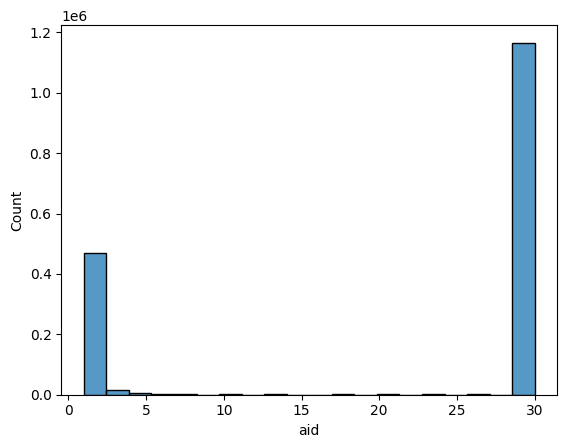

In [ ]:
sns.histplot(
    data=pred_df_buys_list.groupby('session', as_index=False).agg({'aid' : 'count'}),
    x='aid',
    bins=20
)

Noted that most users have 30 candidates selected. A few candidates do not, possibly due to them not having enough available information to select candidates.

In [ ]:
# pred_df_buys_list.to_parquet("/content/drive/MyDrive/0.capstone/covisit_prepare/ranker_candidates_test_3.parquet", index=False)